In [9]:
import numpy as np
import sklearn.metrics
from tqdm import tqdm

import sys
import traceback

In [1]:
from matplotlib import pyplot as plt
import seaborn as sb

In [25]:
sb.set_theme(context='talk', style='white')

In [3]:
def generate_original_bcm(N, T, interactions_per_timestep=10, mu=0.1, eps=.6, beta=8, seed=None):
    if seed is not None:
        np.random.seed(seed)
        
    sigmoid = lambda x: 1. / (1 + np.exp(-beta * x))

    x0 = np.random.uniform(size=N) * 2 - 1
    
    u_v_t_w = []
    
    t = 0
    X = [x0]

    for t in range(T):
        xt = X[-1]
        
        xtp1 = xt.copy()
        for _ in range(interactions_per_timestep):
            i = np.random.randint(N)
            while True:
                j = np.random.randint(N)
                if i != j: break

            dist = np.abs(xt[i] - xt[j])
            if dist < eps:
                xtp1[i] += mu * (xt[j] - xt[i])
                xtp1[j] += mu * (xt[i] - xt[j])
                u_v_t_w.append( (i, j, t, 1) )
            else:
                u_v_t_w.append( (i, j, t, 0) )
            xtp1 = np.clip(xtp1, -1, 1)

        X.append(xtp1)

    X = np.vstack(X)

    return u_v_t_w, X

In [4]:
def generate_learnable_bcm(N, T, interactions_per_timestep=10, mu=0.1, eps=.6, beta=8, seed=None):
    if seed is not None:
        np.random.seed(seed)
        
    sigmoid = lambda x: 1. / (1 + np.exp(-beta * x))

    x0 = np.random.uniform(size=N) * 2 - 1
    
    u_v_t_w = []
    
    t = 0
    X = [x0]
    count = [0]
    for t in range(T):
        xt = X[-1]
        ct = 0
        xtp1 = xt.copy()
        for _ in range(interactions_per_timestep):
            i = np.random.randint(N)
            while True:
                j = np.random.randint(N)
                if i != j: break

            dist = np.abs(xt[i] - xt[j])
            p = sigmoid(eps-dist)
            extraction = np.random.uniform()
            if p>=extraction:
                if dist>eps:
                    ct+=1
                xtp1[i] += mu * (xt[j] - xt[i])
                xtp1[j] += mu * (xt[i] - xt[j])
                u_v_t_w.append( (i, j, t, 1) )
            else:
                u_v_t_w.append( (i, j, t, 0) )
            xtp1 = np.clip(xtp1, -1, 1)
        
        X.append(xtp1)
        count.append(ct)

    X = np.vstack(X)

    return u_v_t_w, X, count

In [6]:
def likelihood(X, Et, N, T, eps=.25, mu=.1, beta=8, seed=None):
    if seed is not None:
        np.random.seed(seed)
        
    sigmoid = lambda x: 1. / (1 + np.exp(-beta * x))
    
    # l = np.log(1/(N*N))
    l = 1
    for i, j, t, w in Et:
        xt = X[t]
        dist = np.abs(xt[i]-xt[j])
        if w == 1:
            l = l * sigmoid(eps-dist)
        else:
            l = l * (1-sigmoid(eps-dist))
        
    return l

In [7]:
def log_likelihood(X, Et, N, T, eps=.25, mu=.1, beta=8, seed=None):
    if seed is not None:
        np.random.seed(seed)
        
    sigmoid = lambda x: 1. / (1 + np.exp(-beta * x))
    
    # l = np.log(1/(N*N))
    l = 0
    lt = np.zeros(T)
    for i, j, t, w in Et:
        xt = X[t]
        dist = np.abs(xt[i]-xt[j])
        if w == 1:
            l += np.log(sigmoid(eps-dist))
            lt[t] += np.log(sigmoid(eps-dist))
        else:
            l += np.log(1-sigmoid(eps-dist))
            lt[t] += np.log(1-sigmoid(eps-dist))
        
    return l, lt

In [ ]:
import matplotlib as mpl

In [34]:
COLOR = 'white'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

In [36]:
def plot_opinions_in_time(X):
    fig, ax = plt.subplots(figsize=(5, 4))
    ax.plot(X, '-')#, bins=np.arange(-1, 1, 0.1), cmap='afmhot')
    ax.set_ylim((-1.05, 1.05))
    ax.set_xlabel("time")
    ax.set_ylabel(r"$\mathbf{x}$")
    ax.set_yticks([-1, 0, 1])
    return fig, ax

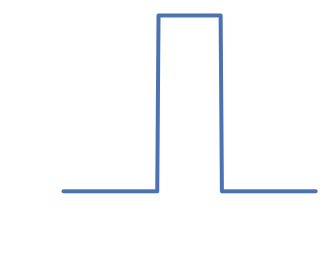

In [110]:
beta = 50
eps = .5
H = lambda x: 1 if eps-np.abs(x)>0 else 0
fig, ax = plt.subplots(figsize=(5, 4))
x = np.linspace(-2, 2, 200, endpoint=True)
y = [H(i) for i in x]
ax.plot(x, y, lw=4)
ax.set_xticks([-2, 0, 2])
ax.set_yticks([0., 1.])
ax.set_ylabel(r"$p$")
ax.set_xlabel(r"$\varepsilon-|x_{i,t}-x_{j, t}|$")
sb.despine(left=True, bottom=True)
plt.tight_layout()
fig.savefig('original.pdf', transparent=True)

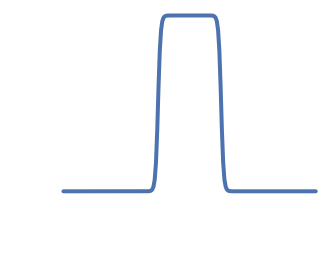

In [111]:
beta = 50
eps = .5
sigmoid = lambda x: 1. / (1 + np.exp(-beta * x))
fig, ax = plt.subplots(figsize=(5, 4))
x = np.linspace(-2, 2, 200, endpoint=True)
y = sigmoid(eps - np.abs(x))
ax.plot(x, y, lw=4)
ax.set_xticks([-2, 0, 2])
ax.set_yticks([0., 1.])
ax.set_ylabel(r"$p$")
ax.set_xlabel(r"$\varepsilon-|x_{i,t}-x_{j, t}|$")
sb.despine(left=True, bottom=True)
plt.tight_layout()
fig.savefig('sigmoid.pdf', transparent=True)

In [85]:
N = 100
T = 10000
mu = 0.01
eps = 0.75
beta = 50

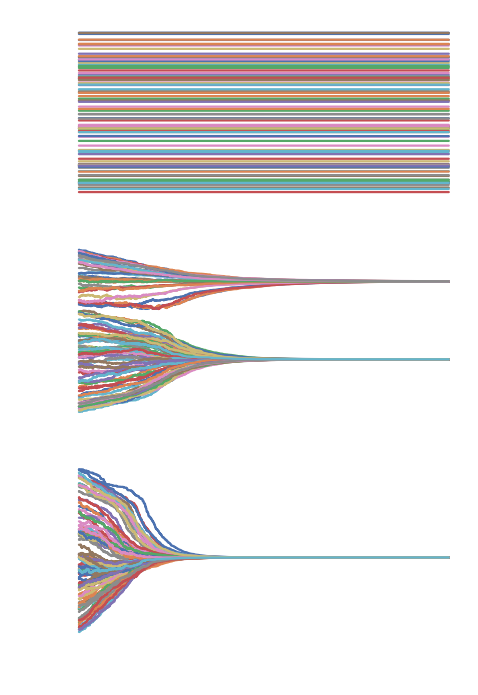

In [96]:
fig, axs = plt.subplots(3, 1, figsize=(7, 10), sharex=True)
for i, eps in enumerate([0.01, 0.5, 0.75]):
    Et, X = generate_original_bcm(N, T, mu=mu, eps=eps, beta=beta)
    axs[i].plot(X, '-')#, bins=np.arange(-1, 1, 0.1), cmap='afmhot')
    axs[i].set_ylim((-1.05, 1.05))
    axs[i].set_ylabel(r"$\mathbf{x}$")
    axs[i].set_yticks([-1, 0, 1])
    axs[i].set_title(r"$\varepsilon$ = "+str(eps))
    axs[i].set_xlabel("")
axs[2].set_xlabel("time")
sb.despine(left=True, bottom=True)
plt.tight_layout()
fig.savefig('dynamics.pdf', transparent=True)

In [12]:
eps_range = np.linspace(0, 1, 101, endpoint=True)
beta_range = np.linspace(0, 100, 101, endpoint=True)

In [13]:
hmap = np.zeros((eps_range.shape[0], beta_range.shape[0]))
for i, eps in tqdm(enumerate(eps_range)):
    for j, beta in enumerate(beta_range):
        l = likelihood(X, Et, N, T, mu=mu, eps=eps, beta=beta)
        hmap[i, j] = l

101it [07:14,  4.30s/it]


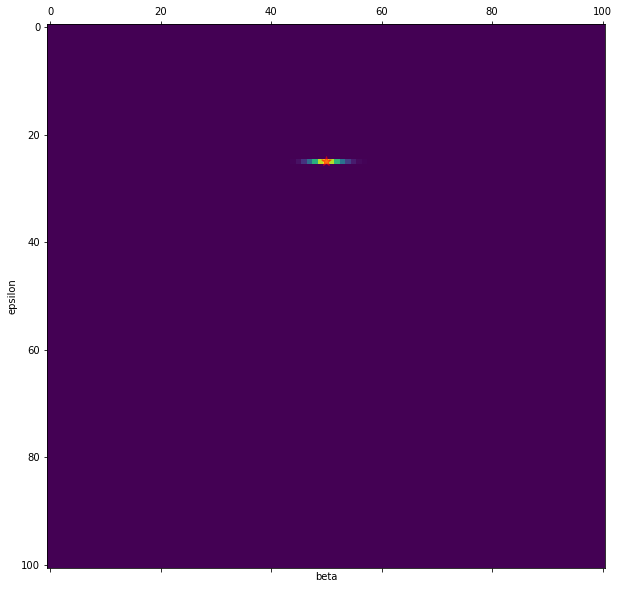

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(hmap, aspect='auto')
ax.set_xlabel('beta')
ax.set_ylabel('epsilon')

# ax.set_xticks(range(0, len(beta_range), 20));
# ax.set_xticklabels(np.round(beta_range[range(0, 101, 20)], 2));
# ax.set_yticks(range(0, len(eps_range), 20));
# ax.set_yticklabels(np.round(eps_range[range(0, 101, 20)], 2));

ax.scatter([50], [25], marker = '*', c='r', s=100, alpha=.5)

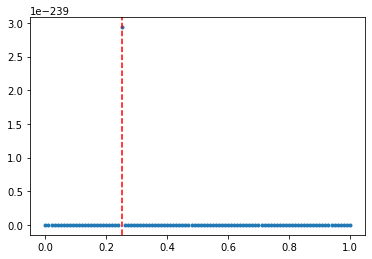

In [15]:
plt.plot(eps_range, hmap[:, 50],ls='None', marker='.')
plt.axvline(.25, c='r', ls='--')

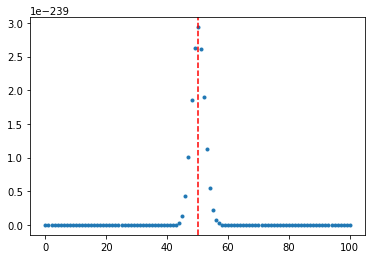

In [16]:
plt.plot(beta_range, hmap[25, :],ls='None', marker='.')
plt.axvline(50, c='r', ls='--')

In [17]:
N = 100
T = 1000
mu = 0.1
eps = 0.25
beta = 50

In [18]:
Et, X = generate_learnable_bcm(N, T, mu=mu, eps=eps, beta=beta)

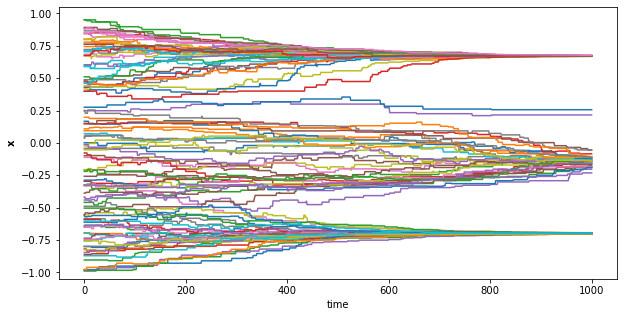

In [19]:
plot_opinions_in_time(X)

In [20]:
eps_range = np.linspace(0, 1, 101, endpoint=True)
beta_range = np.linspace(0, 100, 101, endpoint=True)

In [21]:
hmap = np.zeros((eps_range.shape[0], beta_range.shape[0]))
for i, eps in tqdm(enumerate(eps_range)):
    for j, beta in enumerate(beta_range):
        l = likelihood(X, Et, N, T, mu=mu, eps=eps, beta=beta)
        hmap[i, j] = l

101it [04:21,  2.59s/it]


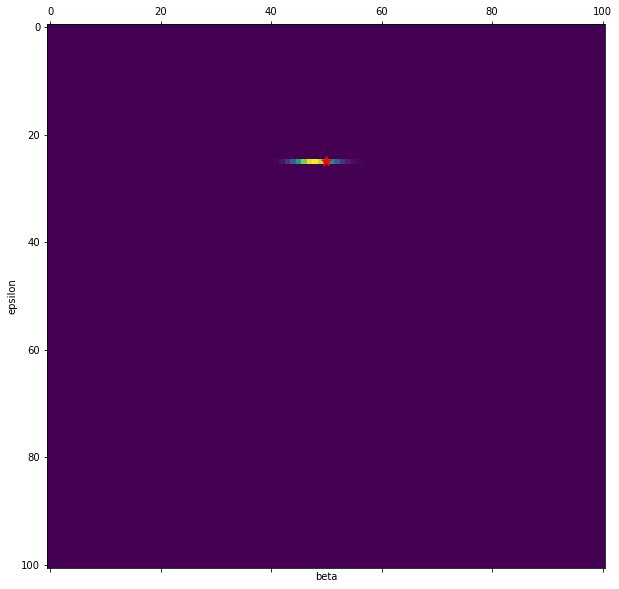

In [22]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(hmap, aspect='auto')
ax.set_xlabel('beta')
ax.set_ylabel('epsilon')

# ax.set_xticks(range(0, len(beta_range), 20));
# ax.set_xticklabels(np.round(beta_range[range(0, 101, 20)], 2));
# ax.set_yticks(range(0, len(eps_range), 20));
# ax.set_yticklabels(np.round(eps_range[range(0, 101, 20)], 2));

ax.scatter([50], [25], marker = '*', c='r', s=100)

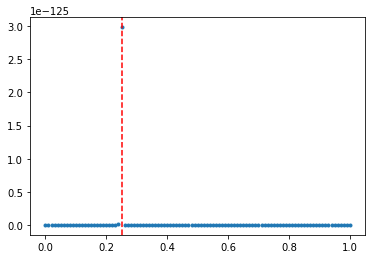

In [23]:
plt.plot(eps_range, hmap[:, 50],ls='None', marker='.')
plt.axvline(.25, c='r', ls='--')

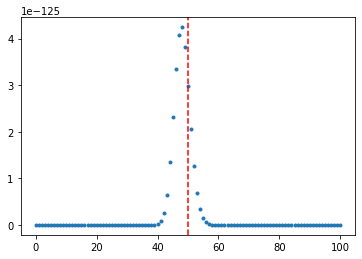

In [24]:
plt.plot(beta_range, hmap[25, :],ls='None', marker='.')
plt.axvline(50, c='r', ls='--')

In [25]:
N = 100
T = 1000
mu = 0.5
eps = 0.25
beta = 50

In [26]:
Et, X = generate_learnable_bcm(N, T, mu=mu, eps=eps, beta=beta)

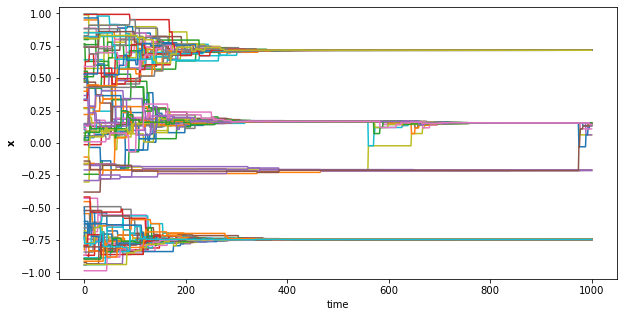

In [27]:
plot_opinions_in_time(X)

In [28]:
eps_range = np.linspace(0, 1, 101, endpoint=True)
beta_range = np.linspace(0, 100, 101, endpoint=True)

In [29]:
hmap = np.zeros((eps_range.shape[0], beta_range.shape[0]))
for i, eps in tqdm(enumerate(eps_range)):
    for j, beta in enumerate(beta_range):
        l = likelihood(X, Et, N, T, mu=mu, eps=eps, beta=beta)
        hmap[i, j] = l

101it [04:25,  2.63s/it]


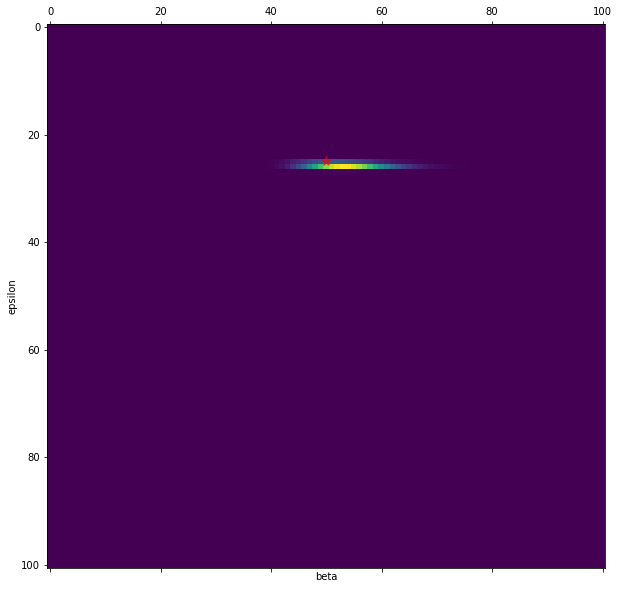

In [30]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(hmap, aspect='auto')
ax.set_xlabel('beta')
ax.set_ylabel('epsilon')

# ax.set_xticks(range(0, len(beta_range), 20));
# ax.set_xticklabels(np.round(beta_range[range(0, 101, 20)], 2));
# ax.set_yticks(range(0, len(eps_range), 20));
# ax.set_yticklabels(np.round(eps_range[range(0, 101, 20)], 2));

ax.scatter([50], [25], marker = '*', c='r', s=100, alpha=.5)

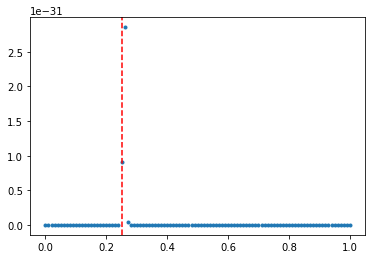

In [31]:
plt.plot(eps_range, hmap[:, 50],ls='None', marker='.')
plt.axvline(.25, c='r', ls='--')

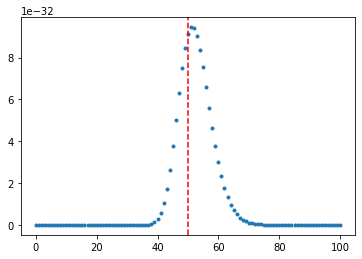

In [32]:
plt.plot(beta_range, hmap[25, :],ls='None', marker='.')
plt.axvline(50, c='r', ls='--')

In [34]:
N = 100
T = 1000
mu = 0.5
eps = 0.25
beta = 50

In [35]:
Et, X = generate_learnable_bcm(N, T, mu=mu, eps=eps, beta=beta)

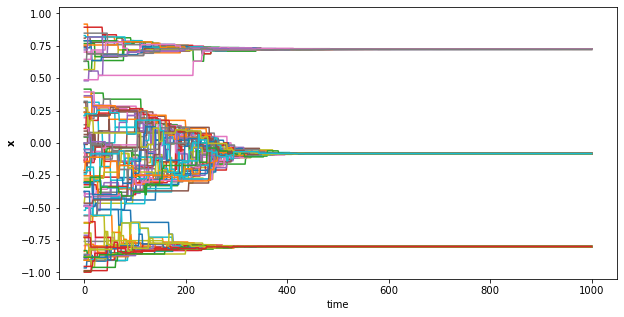

In [36]:
plot_opinions_in_time(X)

In [37]:
eps_range = np.linspace(0, 1, 101, endpoint=True)
beta_range = np.linspace(0, 100, 101, endpoint=True)

In [38]:
hmap = np.zeros((eps_range.shape[0], beta_range.shape[0]))
for i, eps in tqdm(enumerate(eps_range)):
    for j, beta in enumerate(beta_range):
        l, _ = log_likelihood(X, Et, N, T, mu=mu, eps=eps, beta=beta)
        hmap[i, j] = l

47it [04:39,  5.94s/it]/var/folders/5m/nwnx4mss4mv83fd9k_8vf3wh0000gn/T/ipykernel_86844/2755121724.py:17: RuntimeWarning: divide by zero encountered in log
  l += np.log(1-sigmoid(eps-dist))
/var/folders/5m/nwnx4mss4mv83fd9k_8vf3wh0000gn/T/ipykernel_86844/2755121724.py:18: RuntimeWarning: divide by zero encountered in log
  lt[t] += np.log(1-sigmoid(eps-dist))
101it [10:00,  5.95s/it]


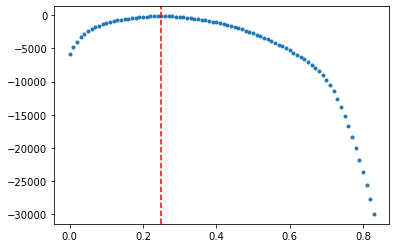

In [40]:
plt.plot(eps_range, hmap[:, 50],ls='None', marker='.')
plt.axvline(.25, c='r', ls='--')

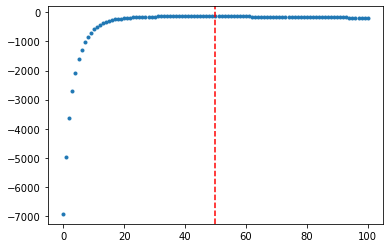

In [41]:
plt.plot(beta_range, hmap[25, :],ls='None', marker='.')
plt.axvline(50, c='r', ls='--')

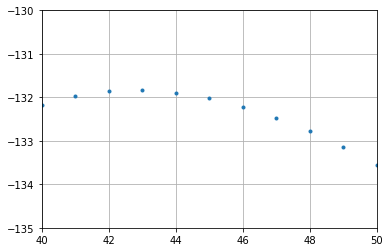

In [79]:
plt.plot(beta_range, hmap[25, :],ls='None', marker='.')
plt.ylim([-135, -130])
plt.xlim([40, 50])
plt.grid(True)

In [62]:
np.argsort(hmap[25, :])[-1]

43

In [61]:
np.argsort(hmap[:, 50])[-1]

25

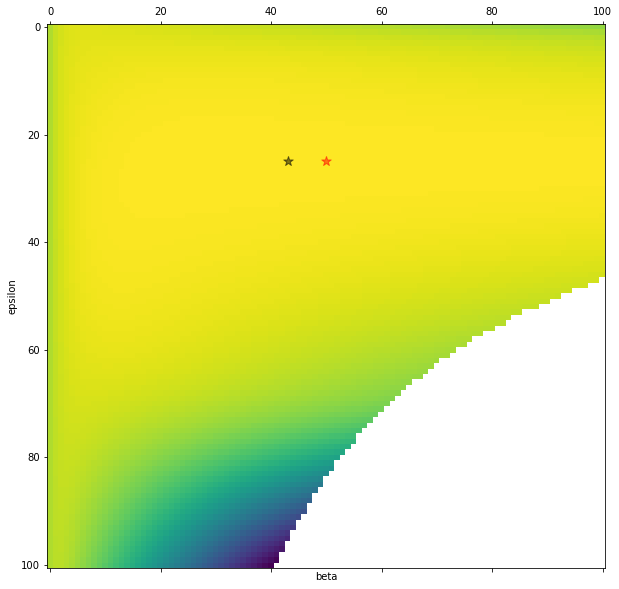

In [63]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(hmap, aspect='auto')
ax.set_xlabel('beta')
ax.set_ylabel('epsilon')

# ax.set_xticks(range(0, len(beta_range), 20));
# ax.set_xticklabels(np.round(beta_range[range(0, 101, 20)], 2));
# ax.set_yticks(range(0, len(eps_range), 20));
# ax.set_yticklabels(np.round(eps_range[range(0, 101, 20)], 2));

ax.scatter([50], [25], marker = '*', c='r', s=100, alpha=.5)
ax.scatter([43], [25], marker = '*', c='black', s=100, alpha=.5)

In [71]:
np.argsort(hmap, axis=None)[-1]%len(beta_range), np.argsort(hmap, axis=None)[-1]//len(eps_range)

(43, 25)

In [89]:
ltlist = []
eps = .25
for beta in [43, 50]:
    l, lt = log_likelihood(X, Et, N, T, mu=mu, eps=eps, beta=beta)
    ltlist.append(lt)

In [97]:
(ltlist[0].sum()-ltlist[1].sum())

1.7205222383623493

In [99]:
diff = (ltlist[0]-ltlist[1])

In [107]:
(diff>0)[:400]

array([False, False, False, False, False, False,  True, False, False,
       False, False, False, False,  True, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
        True, False, False, False,  True, False,  True, False,  True,
       False, False, False, False, False, False, False,  True, False,
       False, False,  True, False, False, False, False, False, False,
       False,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False,  True, False, False,  True, False, False, False,
        True, False, False, False, False,  True, False, False, False,
       False,  True,  True, False, False, False, False,  True, False,
        True, False,  True, False, False, False, False, False,  True,
       False, False,  True, False,  True, False, False, False, False,
        True, False,

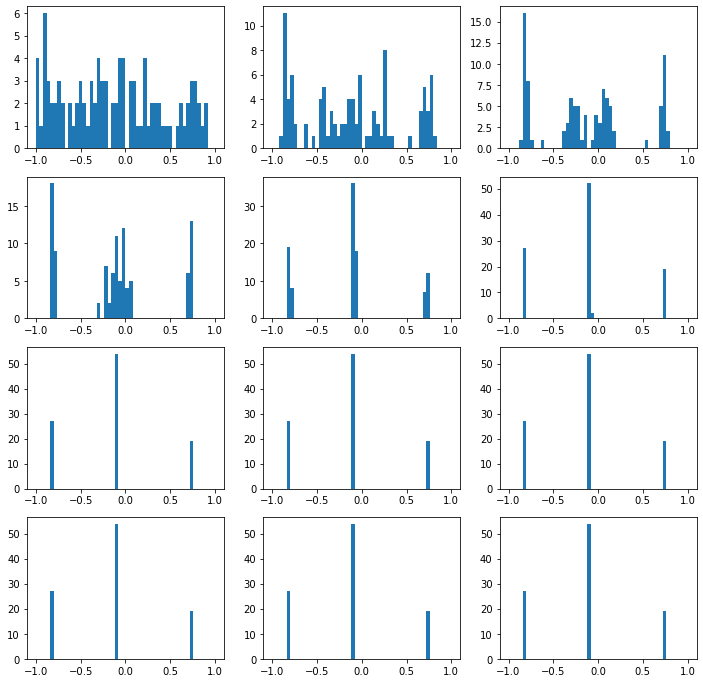

In [139]:
fig, axs = plt.subplots(4, 3, figsize=(12, 12))
for i, t in enumerate(np.linspace(0, len(X), 12, endpoint=False)):
    axs.flatten()[i].hist(X[int(t)], bins=np.linspace(-1, 1, 51));

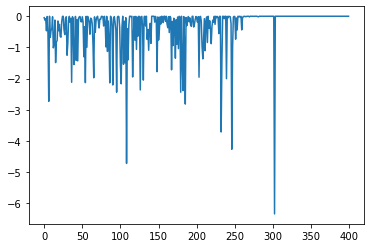

In [164]:
plt.plot(ltlist[0][:400])

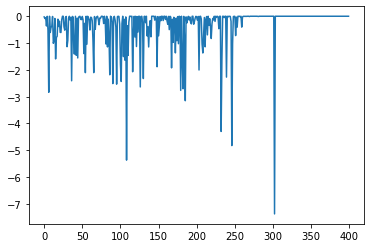

In [165]:
plt.plot(ltlist[1][:400])

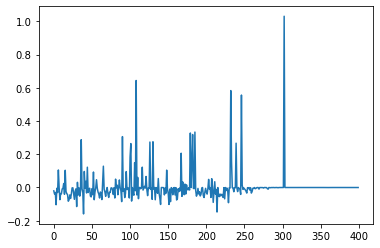

In [167]:
plt.plot(ltlist[0][:400]-ltlist[1][:400])

In [141]:
N = 100
T = 1000
mu = 0.
eps = 0.25
beta = 50

In [142]:
Et, X = generate_learnable_bcm(N, T, mu=mu, eps=eps, beta=beta)

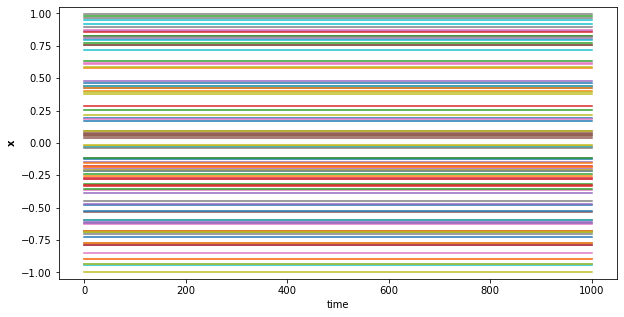

In [143]:
plot_opinions_in_time(X)

In [144]:
eps_range = np.linspace(0, 1, 101, endpoint=True)
beta_range = np.linspace(0, 100, 101, endpoint=True)

In [145]:
hmap = np.zeros((eps_range.shape[0], beta_range.shape[0]))
for i, eps in tqdm(enumerate(eps_range)):
    for j, beta in enumerate(beta_range):
        l, _ = log_likelihood(X, Et, N, T, mu=mu, eps=eps, beta=beta)
        hmap[i, j] = l

44it [04:22,  6.01s/it]/var/folders/5m/nwnx4mss4mv83fd9k_8vf3wh0000gn/T/ipykernel_86844/2755121724.py:17: RuntimeWarning: divide by zero encountered in log
  l += np.log(1-sigmoid(eps-dist))
/var/folders/5m/nwnx4mss4mv83fd9k_8vf3wh0000gn/T/ipykernel_86844/2755121724.py:18: RuntimeWarning: divide by zero encountered in log
  lt[t] += np.log(1-sigmoid(eps-dist))
101it [10:05,  6.00s/it]


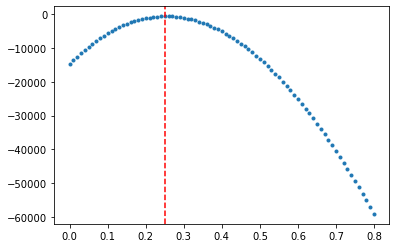

In [146]:
plt.plot(eps_range, hmap[:, 50],ls='None', marker='.')
plt.axvline(.25, c='r', ls='--')

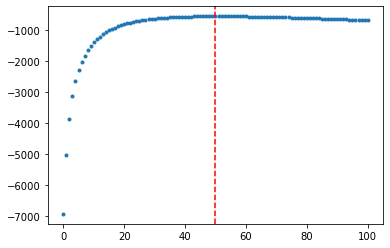

In [147]:
plt.plot(beta_range, hmap[25, :],ls='None', marker='.')
plt.axvline(50, c='r', ls='--')

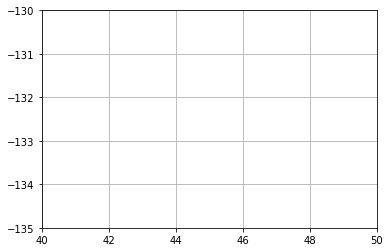

In [148]:
plt.plot(beta_range, hmap[25, :],ls='None', marker='.')
plt.ylim([-135, -130])
plt.xlim([40, 50])
plt.grid(True)

In [151]:
np.argsort(hmap[25, :])[-1]

51

In [152]:
np.argsort(hmap[:, 50])[-1]

25

In [153]:
np.argsort(hmap, axis=None)[-1]%len(beta_range), np.argsort(hmap, axis=None)[-1]//len(eps_range)

(51, 25)

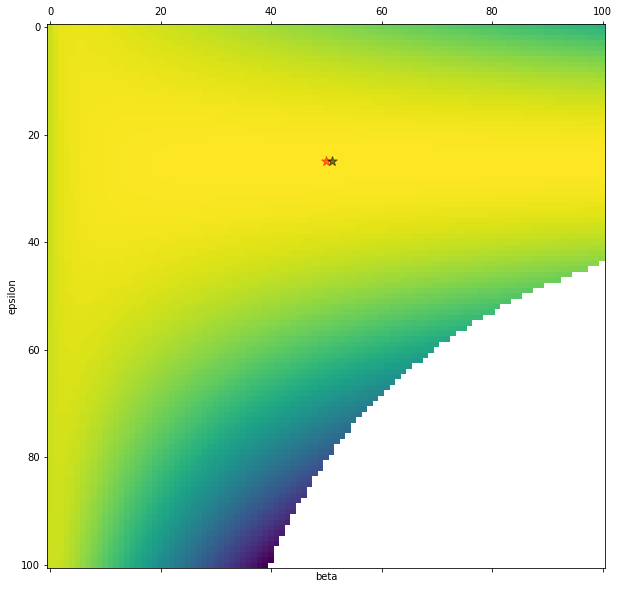

In [154]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(hmap, aspect='auto')
ax.set_xlabel('beta')
ax.set_ylabel('epsilon')

# ax.set_xticks(range(0, len(beta_range), 20));
# ax.set_xticklabels(np.round(beta_range[range(0, 101, 20)], 2));
# ax.set_yticks(range(0, len(eps_range), 20));
# ax.set_yticklabels(np.round(eps_range[range(0, 101, 20)], 2));

ax.scatter([50], [25], marker = '*', c='r', s=100, alpha=.5)
ax.scatter([51], [25], marker = '*', c='black', s=100, alpha=.5)